<a href="https://colab.research.google.com/github/kopmer/bird_classification_project/blob/main/mobilenetV2_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
# PyTorch core libraries for neural network building, optimization, and utilities
import torch                            # Main PyTorch library for tensor operations
import torch.nn as nn                   # Neural network module for layers and loss functions
import torch.optim as optim             # Optimization module with optimizers like SGD, Adam
import torch.nn.functional as F         # Functional API for operations like softmax
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
# TorchVision library for computer vision utilities, models, datasets, and transformations
from torchvision import datasets, models, transforms  # Dataset handling, pre-trained models, and data transforms
from torchvision.models import resnet152, ResNet152_Weights  # Specific imports for ResNet-152 model and weights

# PyTorch utilities for data loading and dataset management
from torch.utils.data import DataLoader, random_split  # DataLoader for batching and random_split for dataset splitting

# PIL library for image processing
from PIL import Image                                  # Image module for handling image loading and conversion

# Additional libraries for supporting functionalities
import random                                          # Random choices for selecting images, shuffling data
import os                                              # OS operations, useful for file and directory management
from tqdm import tqdm                                  # Progress bar tracking, useful for tracking training and data loading progress

# Matplotlib for data visualization, commonly used for plotting training metrics
import matplotlib.pyplot as plt

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Set paths for training and testing data
train_path = "/content/gdrive/MyDrive/classfication_model/input/train_data/train_data"
test_path = "/content/gdrive/MyDrive/classfication_model/input/test_data/test_data"

In [ ]:
# Define transformations with data augmentation for training
train_transform = transforms.Compose([
    # Randomly crop the input image to a size of 224x224 pixels, and resize it back to 224x224
    # This helps introduce some scale variation to make the model more robust
    transforms.RandomResizedCrop(224),

    # Randomly flip the image horizontally with a 50% chance
    # This helps the model generalize better by learning features that are invariant to horizontal flipping
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image by up to ±15 degrees
    # This helps the model become invariant to minor rotations
    transforms.RandomRotation(15),

    # Randomly change the brightness, contrast, saturation, and hue of the image
    # - brightness: adjusts by ±20%
    # - contrast: adjusts by ±20%
    # - saturation: adjusts by ±20%
    # - hue: adjusts by ±10%
    # This color jittering helps the model become robust to different lighting conditions
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    # Convert the image to a tensor, changing the data from a PIL Image or numpy array
    # to a PyTorch tensor format with pixel values normalized to [0, 1]
    transforms.ToTensor(),

    # Normalize the tensor using mean and standard deviation values for each color channel
    # - mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
    # These values are typically used for images pre-trained on ImageNet and help the model
    # to converge faster and maintain consistency with pre-trained models
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformations for validation and test data (without data augmentation)
test_transform = transforms.Compose([
    # Resize the image to 224x224 pixels
    # Since this is for validation/testing, we don't use random cropping, just resizing
    # to maintain consistency across evaluations
    transforms.Resize((224, 224)),

    # Convert the image to a tensor, changing the data from a PIL Image or numpy array
    # to a PyTorch tensor format with pixel values normalized to [0, 1]
    transforms.ToTensor(),

    # Normalize the tensor using the same mean and standard deviation values
    # as in the training transform to maintain consistency
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Load the full training dataset
full_train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

# Split into training and validation sets (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Load the test dataset
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
### mobile 모델
# Define the device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# MobileNetV2 모델 불러오기
model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

num_classes = len(full_train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.last_channel, num_classes)
)

model = model.to(device)

if hasattr(model, 'classifier'):  # MobileNet, EfficientNet 등
  for param in model.classifier.parameters():
      param.requires_grad = True

In [ ]:
# Define the device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the ResNet-152 model with pre-trained weights
model = resnet152(weights=ResNet152_Weights.DEFAULT)

# Modify the final fully connected layer with Dropout for regularization and custom number of classes
num_classes = len(full_train_dataset.classes)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout with 50% rate to help prevent overfitting
    nn.Linear(512, num_classes)
)

# Move the entire model to the specified device
model = model.to(device)

# Unfreeze the last two layers for fine-tuning
for name, param in model.named_parameters():
    if 'layer3' in name or 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False  # Freeze other layers

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 113MB/s] 


In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)  # Adjust weight decay for L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [ ]:
# Hyperparameters
num_epochs = 80

# Lists to store training and validation losses across epochs
train_losses, val_losses = [], []

# Outer tqdm progress bar for epoch tracking
with tqdm(total=num_epochs, desc="Overall Training Progress") as epoch_progress:
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Show detailed tqdm progress only every 10 epochs
        if (epoch + 1) % 20 == 0:
            train_desc = f'Epoch {epoch+1}/{num_epochs} - Training'
            val_desc = 'Validation Loop'
            show_progress = True
        else:
            train_desc = ''
            val_desc = ''
            show_progress = False

        # Training phase
        for images, labels in tqdm(train_loader, desc=train_desc, disable=not show_progress):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)

        # Compute average training loss for this epoch
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=val_desc, disable=not show_progress):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)

        # Compute average validation loss for this epoch
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Update the overall epoch progress bar with the current epoch
        epoch_progress.update(1)

        # Print the training and validation losses every 10 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

        # Step the learning rate scheduler at the end of each epoch
        scheduler.step(val_loss)

        # Update loss information in tqdm every 10 epochs
        if (epoch + 1) % 20 == 0:
            tqdm.write(f"Epoch {epoch+1}/{num_epochs} completed - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 20/80 - Training: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

Overall Training Progress:  25%|██▌       | 20/80 [01:40<05:02,  5.04s/it]

Epoch 20/80 - Train Loss: 0.4441 - Validation Loss: 0.4179
Epoch 20/80 completed - Train Loss: 0.4441, Val Loss: 0.4179


Epoch 40/80 - Training: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

Overall Training Progress:  50%|█████     | 40/80 [03:21<03:22,  5.07s/it]

Epoch 40/80 - Train Loss: 0.2755 - Validation Loss: 0.3023
Epoch 40/80 completed - Train Loss: 0.2755, Val Loss: 0.3023


Epoch 60/80 - Training: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

Overall Training Progress:  75%|███████▌  | 60/80 [05:01<01:38,  4.94s/it]

Epoch 60/80 - Train Loss: 0.2646 - Validation Loss: 0.2920
Epoch 60/80 completed - Train Loss: 0.2646, Val Loss: 0.2920


Epoch 80/80 - Training: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

Overall Training Progress: 100%|██████████| 80/80 [06:42<00:00,  5.04s/it]

Epoch 80/80 - Train Loss: 0.2222 - Validation Loss: 0.2722
Epoch 80/80 completed - Train Loss: 0.2222, Val Loss: 0.2722


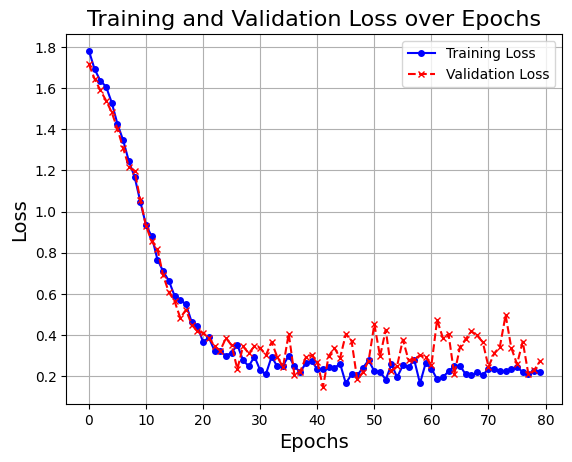

In [ ]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', marker='x', markersize=4)

# Add title and labels
plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Show legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Optionally, set a range for the y-axis for clarity (if you know the expected loss range)
# plt.ylim(0, 2)  # Adjust according to your loss scale

# Show plot
plt.show()

<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4453 (\N{HANGUL JUNGSEONG EO}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4535 (\N{HANGUL JONGSEONG MIEUM}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4363 (\N{HANGUL CHOSEONG IEUNG}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4467 (\N{HANGUL JUNGSEONG EU}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4523 (\N{HANGUL JONGSEONG NIEUN}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4355 (\N{HANGUL CHOSEONG TIKEUT}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning:

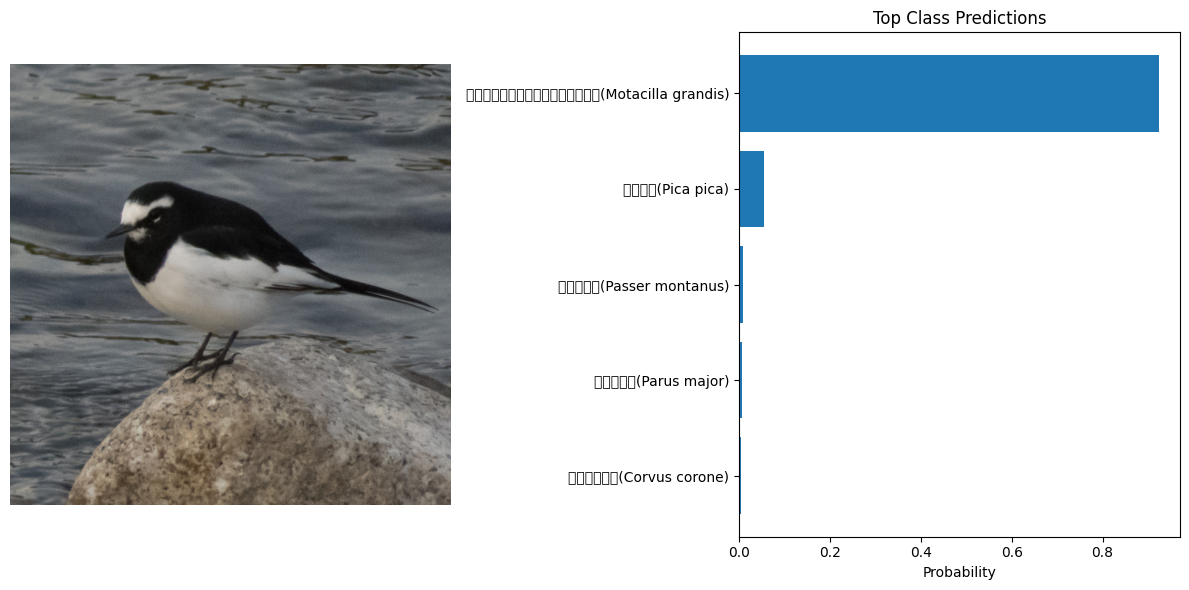

Image 1:
  Actual class: 검은등할미새(Motacilla grandis)
  Predicted class: 검은등할미새(Motacilla grandis)
------------------------------


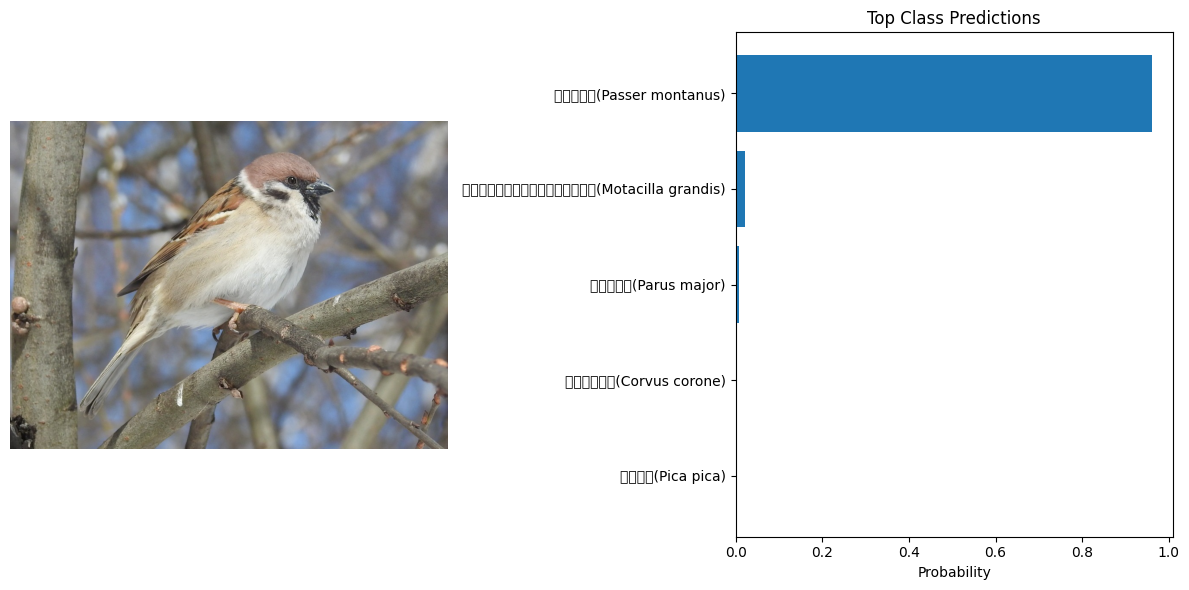

Image 2:
  Actual class: 참새(Passer montanus)
  Predicted class: 참새(Passer montanus)
------------------------------


<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4457 (\N{HANGUL JUNGSEONG O}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4364 (\N{HANGUL CHOSEONG CIEUC}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4462 (\N{HANGUL JUNGSEONG U}) missing from current font.
  plt.tight_layout()


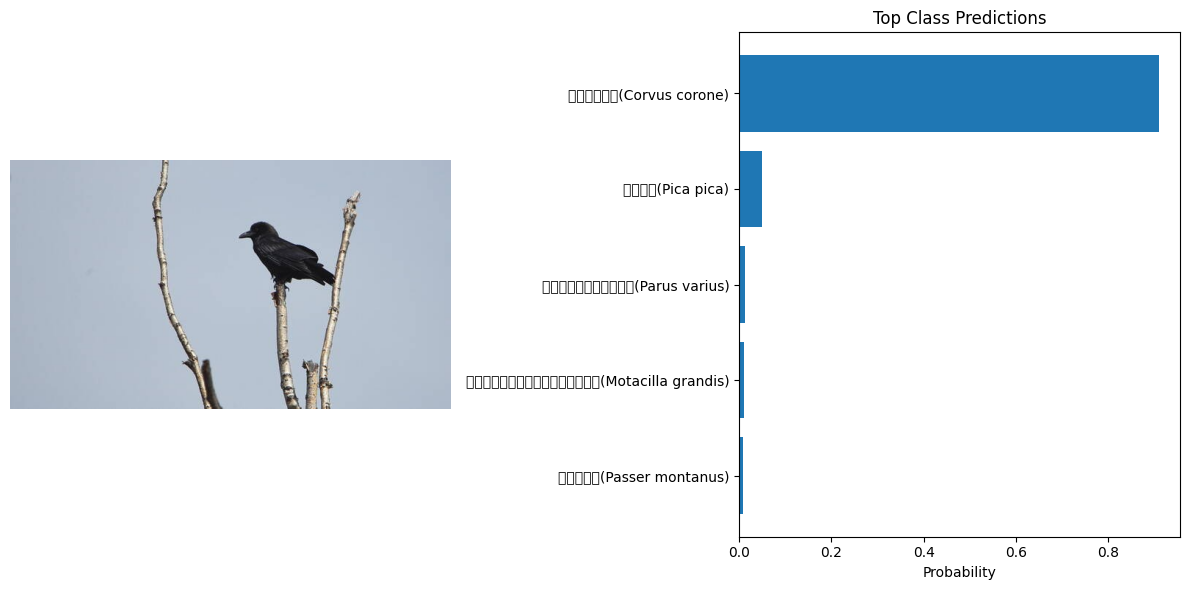

Image 3:
  Actual class: 까마귀(Corvus corone)
  Predicted class: 까마귀(Corvus corone)
------------------------------


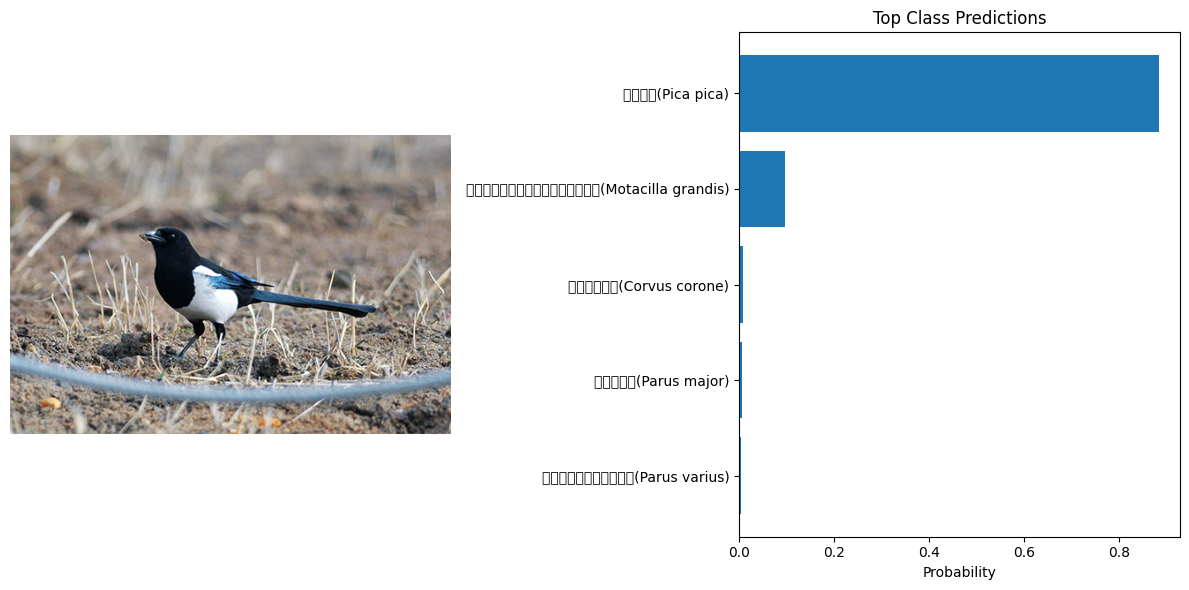

Image 4:
  Actual class: 까치(Pica pica)
  Predicted class: 까치(Pica pica)
------------------------------


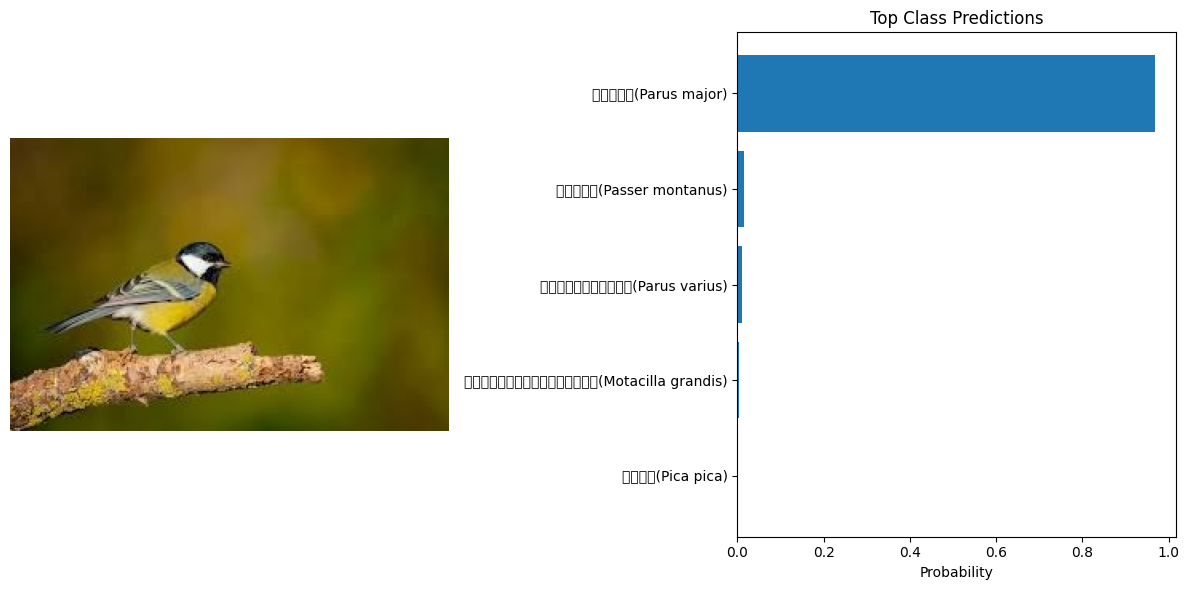

Image 5:
  Actual class: 박새(Parus major)
  Predicted class: 박새(Parus major)
------------------------------


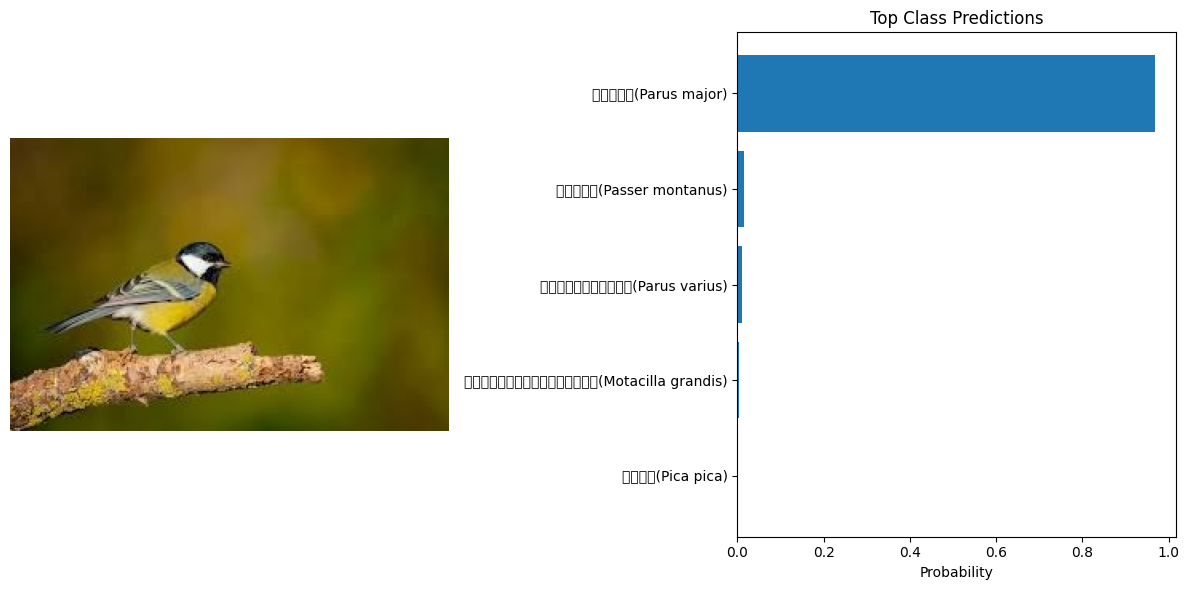

Image 6:
  Actual class: 박새(Parus major)
  Predicted class: 박새(Parus major)
------------------------------


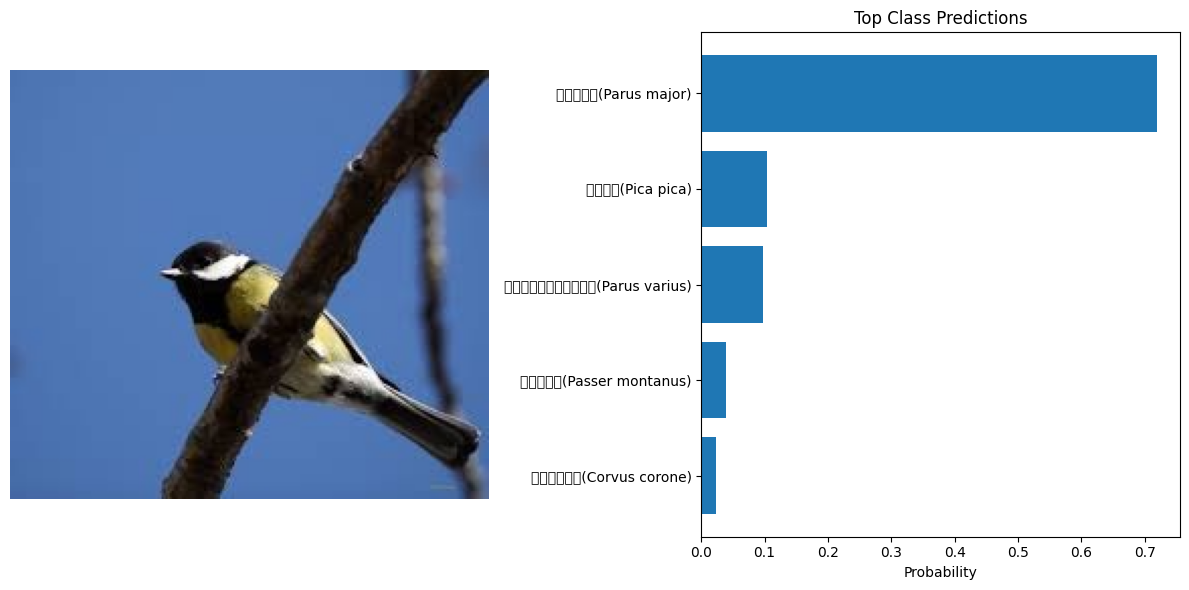

Image 7:
  Actual class: 박새(Parus major)
  Predicted class: 박새(Parus major)
------------------------------


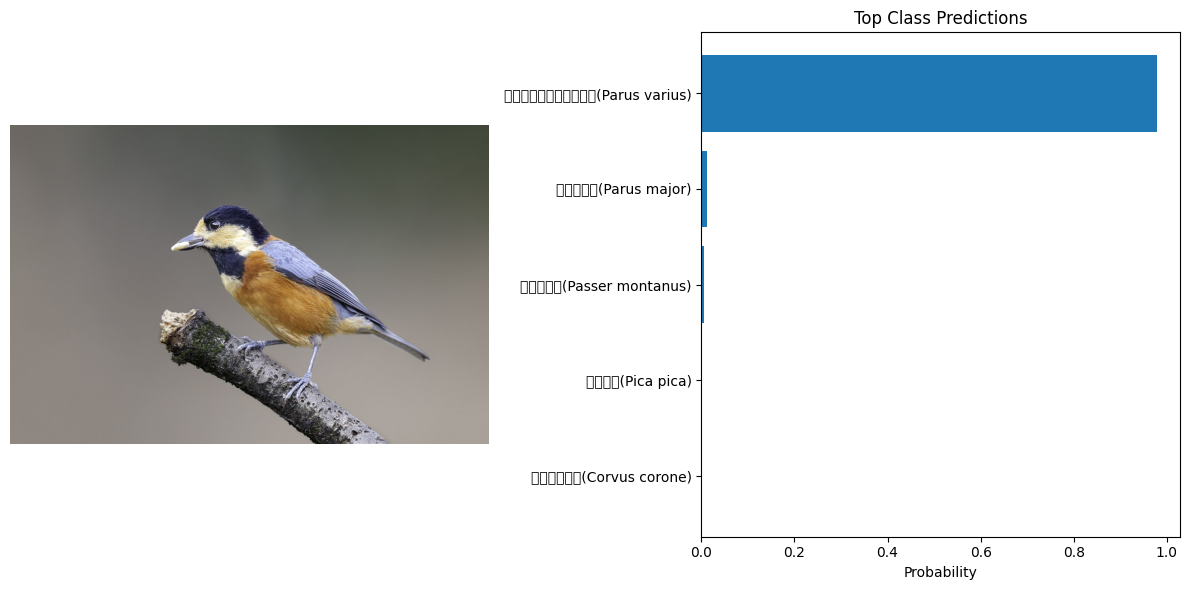

Image 8:
  Actual class: 곤줄박이(Parus varius)
  Predicted class: 곤줄박이(Parus varius)
------------------------------


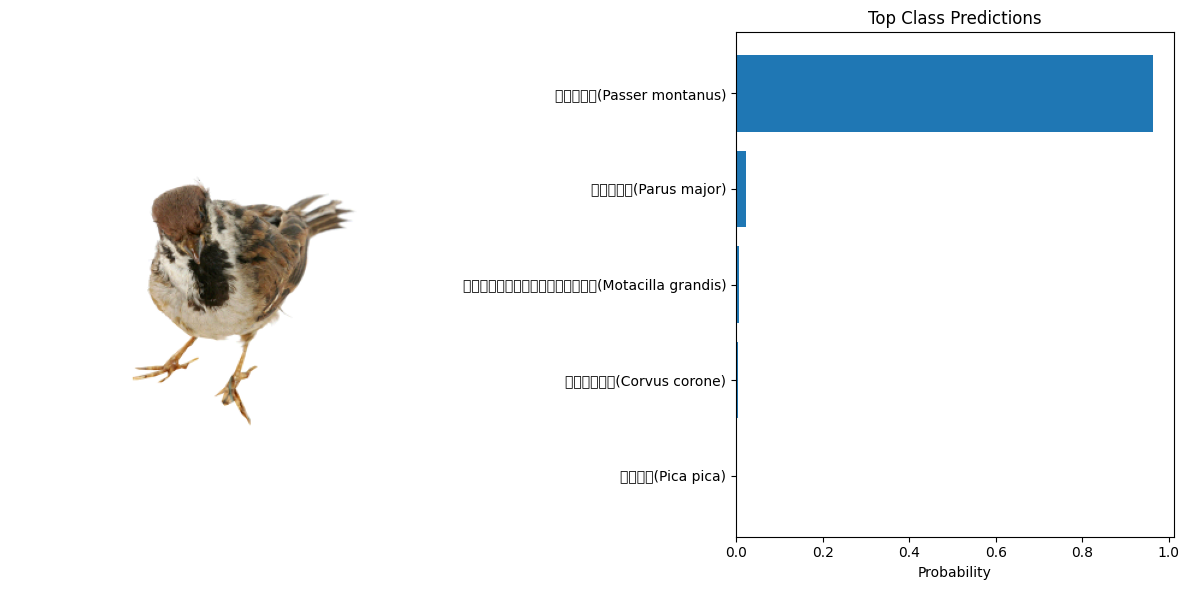

Image 9:
  Actual class: 참새(Passer montanus)
  Predicted class: 참새(Passer montanus)
------------------------------


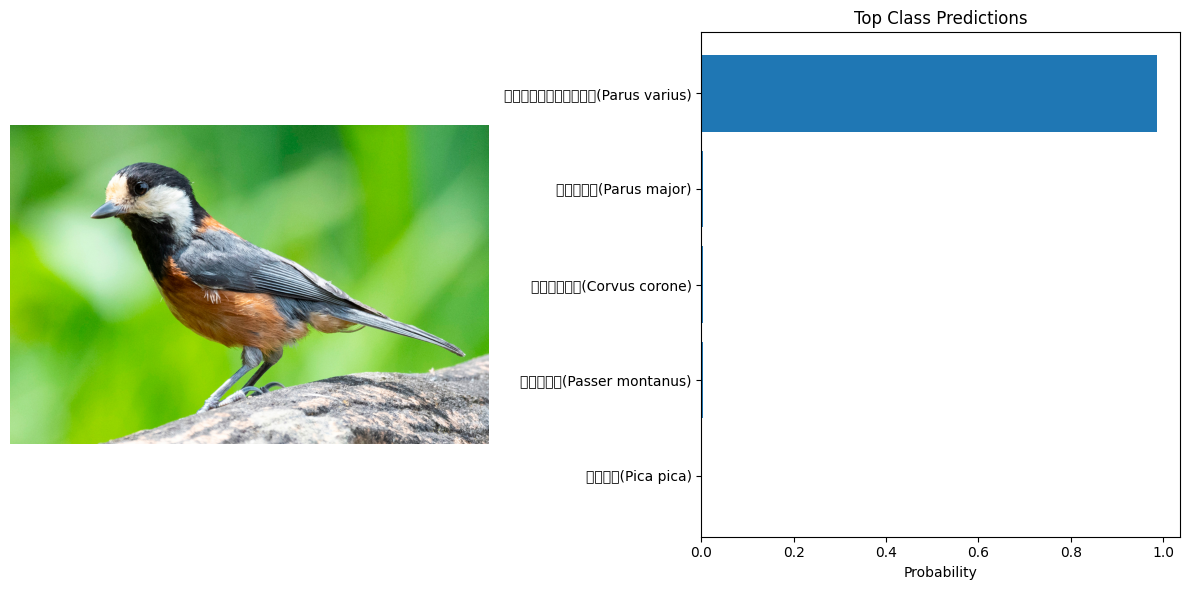

Image 10:
  Actual class: 곤줄박이(Parus varius)
  Predicted class: 곤줄박이(Parus varius)
------------------------------


In [ ]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, transform):
    """
    Loads an image from the specified path, converts it to RGB format, applies transformations,
    and prepares it as a tensor for model input.

    Args:
        image_path (str): The file path of the image to load.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.

    Returns:
        tuple: Original PIL image and preprocessed image tensor ready for model input.
    """
    image = Image.open(image_path).convert("RGB")  # Open and convert image to RGB
    return image, transform(image).unsqueeze(0)     # Apply transformations and add batch dimension


# Prediction function with combined loading, preprocessing, and prediction
def predict_image(model, image_path, transform, device):
    """
    Loads and preprocesses an image, then uses the model to predict class probabilities.

    Args:
        model (torch.nn.Module): Trained model to use for prediction.
        image_path (str): Path to the image file to predict.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        tuple: Original image and class probabilities as a numpy array.
    """
    original_image, image_tensor = load_and_preprocess_image(image_path, transform)  # Load and preprocess image
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.to(device)  # Move image tensor to specified device
        outputs = model(image_tensor)           # Get model outputs
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get class probabilities

    return original_image, probabilities.cpu().numpy().flatten()  # Return image and probabilities


# Visualization function for predictions
def visualize_predictions(image, probabilities, class_names, top_k=5):
    """
    Displays the original image alongside a bar chart of the top-k class predictions.

    Args:
        image (PIL.Image): The original image.
        probabilities (np.array): Array of class probabilities output by the model.
        class_names (list): List of class names corresponding to model output.
        top_k (int): Number of top predictions to display (default is 5).
    """
    top_k_idx = probabilities.argsort()[-top_k:][::-1]         # Get indices of top-k predictions
    top_classes = [class_names[i] for i in top_k_idx]          # Retrieve class names for top-k predictions
    top_probabilities = probabilities[top_k_idx]               # Get probabilities for top-k predictions

    # Plotting the original image and top-k predictions
    fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
    axarr[0].imshow(image)                                     # Display the original image
    axarr[0].axis("off")

    axarr[1].barh(top_classes, top_probabilities)              # Display bar chart for top-k predictions
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Top Class Predictions")
    axarr[1].invert_yaxis()                                    # Display highest probability at the top

    plt.tight_layout()
    plt.show()


# Function to select a random image from the test folder
def get_random_image_from_folder(folder_path):
    """
    Selects a random image from a specified folder structure where images are organized by class.

    Args:
        folder_path (str): Path to the root folder containing subfolders for each class.

    Returns:
        tuple: File path to a randomly selected image and the actual class label.
    """
    classes = os.listdir(folder_path)                          # List all class subfolders in the test folder
    random_class = random.choice(classes)                      # Choose a random class
    class_folder = os.path.join(folder_path, random_class)     # Path to chosen class folder
    image_files = os.listdir(class_folder)                     # List all images in the chosen class folder
    random_image_file = random.choice(image_files)             # Choose a random image from the class folder
    return os.path.join(class_folder, random_image_file), random_class  # Return image path and class


# Example usage to predict and visualize 10 random images
test_folder_path = test_path  # Replace with your test data path
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize images to match model input size
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize as per ImageNet standards
])

class_names = full_train_dataset.classes  # Assuming full_train_dataset.classes provides the class names

# Loop to predict on 10 random images and visualize results
for i in range(10):
    test_image_path, actual_class = get_random_image_from_folder(test_folder_path)  # Select random image
    original_image, probabilities = predict_image(model, test_image_path, transform, device)  # Make prediction
    visualize_predictions(original_image, probabilities, class_names)  # Visualize top predictions

    # Print actual and predicted class
    predicted_class_idx = probabilities.argmax()
    predicted_class = class_names[predicted_class_idx]
    print(f"Image {i+1}:")
    print(f"  Actual class: {actual_class}")
    print(f"  Predicted class: {predicted_class}")
    print("-" * 30)

In [ ]:
model_save_path = "mobile_bird_model.pth"  # 저장할 파일 경로
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to mobile_bird_model.pth


['검은등할미새(Motacilla grandis)', '곤줄박이(Parus varius)', '까마귀(Corvus corone)', '까치(Pica pica)', '박새(Parus major)', '참새(Passer montanus)']


<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4359 (\N{HANGUL CHOSEONG PIEUP}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4449 (\N{HANGUL JUNGSEONG A}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4520 (\N{HANGUL JONGSEONG KIYEOK}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4361 (\N{HANGUL CHOSEONG SIOS}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4450 (\N{HANGUL JUNGSEONG AE}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph 4457 (\N{HANGUL JUNGSEONG O}) missing from current font.
  plt.tight_layout()
<ipython-input-18-1b6c508ee8df>:67: UserWarning: Glyph

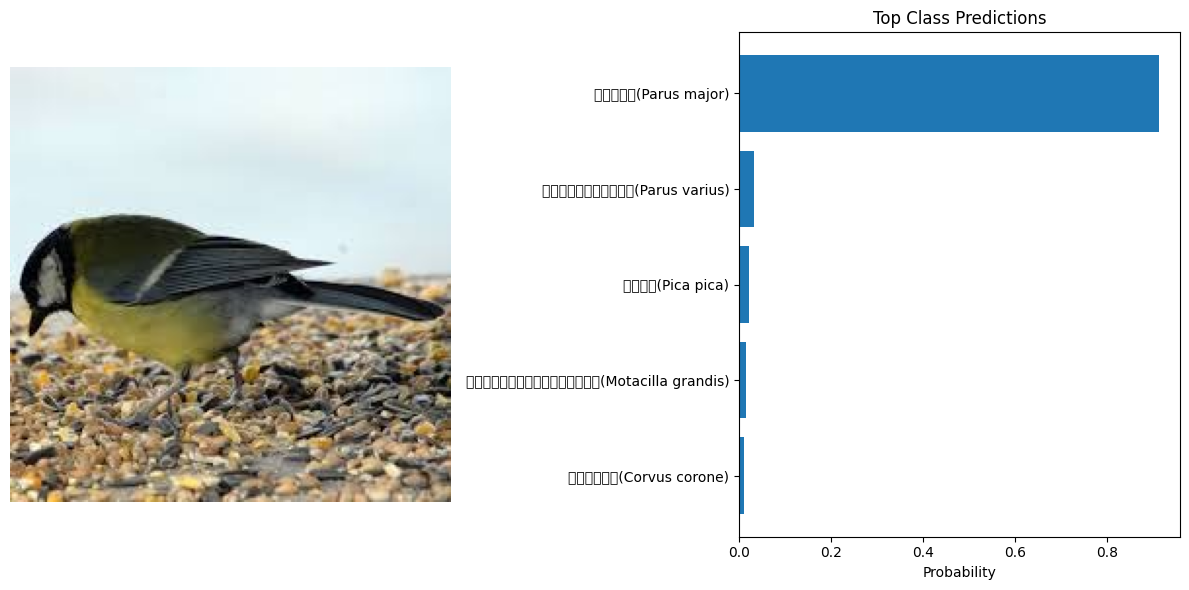

Predicted class: 박새(Parus major)


In [ ]:
# 예측하려는 이미지 경로 지정
image_path = "/content/gdrive/MyDrive/classfication_model/input/test_data/test_data/박새(Parus major)/Parus major (52).jpg"  # 예측할 이미지 경로로 변경

# 모델과 변환 함수 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 이미지 크기 변경
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet 기준으로 정규화
])

# 예측 수행
original_image, probabilities = predict_image(model, image_path, transform, device)
print(class_names)
# 예측 결과 시각화
visualize_predictions(original_image, probabilities, class_names)

# 예측된 클래스 출력
predicted_class_idx = probabilities.argmax()
predicted_class = class_names[predicted_class_idx]
print(f"Predicted class: {predicted_class}")

KeyboardInterrupt: 